# Quantifying Random forest confidence

In [41]:
import pickle
import numpy as np
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

from ad_config_search.rforest_utils import get_prediction_dist

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
with open("model=RF__env-window=200__time=present__env-feats=gt-v2__te=0.43.pl", 'rb') as f:
    dictionary = pickle.load(f)

In [3]:
model = dictionary["model"]
train = dictionary["train"]
train_labels = dictionary["train_labels"]
test = dictionary["test"]
test_labels = dictionary["test_labels"]

### Visually correlating statistics (mean/var) of predicted config scores on an environment with its score relative to baseline

In [10]:
test_predictions = model.predict(test)

[Parallel(n_jobs=144)]: Using backend ThreadingBackend with 144 concurrent workers.
[Parallel(n_jobs=144)]: Done 114 out of 200 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=144)]: Done 200 out of 200 | elapsed:    0.2s finished


In [11]:
stats_per_pred = {
    k: {scenario: v(test_predictions[test.index == scenario]) for scenario in test.index.unique()} for k, v in [
        ("std", np.std),
        ("var", np.var),
        ("range", lambda x: np.max(x) - np.min(x)),
        ("mean", lambda x: np.max(x) - np.min(x))
    ]
}

In [12]:
improvement_by_scenario = {'training_0000-S10': -2.738086363636377,
 'training_0000-S5': -1.9803766497461979,
 'training_0004-S1': -1.81623484848485,
 'training_0000-S19': -1.5882614213198138,
 'training_0000-S17': -1.1654146464646402,
 'training_0003-S20': -1.1606204545454588,
 'training_0003-S18': -0.5432207070707022,
 'training_0004-S14': -0.4733168367347034,
 'training_0000-S4': -0.22366395939085848,
 'training_0003-S11': -0.17799106291339228,
 'training_0000-S23': -0.16394318697175692,
 'training_0000-S22': -0.03955151515151556,
 'training_0000-S12': -0.025465384615383613,
 'training_0000-S1': 0.0,
 'training_0000-S15': 0.0,
 'training_0000-S16': 0.0,
 'training_0002-S9': 0.0,
 'training_0004-S19': 0.016782368175700668,
 'training_0000-S3': 0.0190289340101657,
 'training_0000-S11': 0.03752842639593723,
 'training_0003-S16': 0.043007575757577854,
 'training_0003-S24': 0.18685184693479107,
 'training_0005-S12': 0.33459600416502866,
 'training_0003-S14': 0.3991406091370493,
 'training_0002-S24': 0.4729575757575759,
 'training_0003-S22': 0.5460055837563402,
 'training_0000-S2': 0.6040472582972569,
 'training_0005-S6': 0.7548767676767696,
 'training_0003-S1': 0.9915954545454548,
 'training_0005-S19': 1.0488240620676557,
 'training_0004-S22': 1.1540055837563443,
 'training_0000-S0': 1.1951055837563516,
 'training_0000-S20': 1.2996228426396073,
 'training_0003-S5': 1.4568301874830212,
 'training_0005-S0': 1.837778859820375,
 'training_0002-S4': 2.1918680390765175,
 'training_0003-S9': 2.3991641929499075,
 'training_0005-S23': 2.4603477707006363,
 'training_0000-S21': 2.5419984848484773,
 'training_0000-S6': 2.5564560606060596,
 'training_0002-S6': 2.9833531385281375,
 'training_0003-S7': 3.2347167512690334,
 'training_0004-S16': 3.905184289858081,
 'training_0004-S12': 3.9615427124820997,
 'training_0000-S13': 4.096466583365874,
 'training_0000-S18': 4.827542857142856,
 'training_0004-S5': 5.2031434101262555,
 'training_0000-S14': 5.904958333984119,
 'training_0004-S20': 8.628684430560977}

In [15]:
xs = []
ys = []
stat = "var"
for k in stats_per_pred[stat].keys():
    xs.append(stats_per_pred[stat][k])
    ys.append(improvement_by_scenario[k])

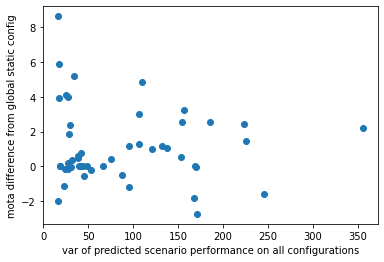

In [20]:
import matplotlib.pyplot as plt
plt.xlabel("{} of predicted scenario performance on all configurations".format(stat))
plt.ylabel("mota difference from global static config")
plt.scatter(xs, ys)

### A contrib scikit learn library for convidence intervals gives all nans...

In [20]:
import forestci as fci

In [21]:
mpg_V_IJ_unbiased = fci.random_forest_error(model, train, test)

/data/ges/miniconda3/envs/erdos_env/lib/python3.6/site-packages/forestci/calibration.py:86: RuntimeWarning: overflow encountered in exp
  g_eta_raw = np.exp(np.dot(XX, eta)) * mask
/data/ges/miniconda3/envs/erdos_env/lib/python3.6/site-packages/forestci/calibration.py:102: RuntimeWarning: invalid value encountered in true_divide
  g_eta_main = g_eta_raw / sum(g_eta_raw)


In [ ]:
# 10:29am

In [24]:
np.all(np.isnan(mpg_V_IJ_unbiased))

True

### Instead of getting configuration with best average of trees, compare for lower quantiles

In [4]:
test_predictions_per_tree = get_prediction_dist(model, test).T

100%|██████████| 200/200 [00:05<00:00, 34.30it/s]


In [5]:
test_predictions_per_tree.shape

(112896, 200)

100%|██████████| 49/49 [00:02<00:00, 20.47it/s]


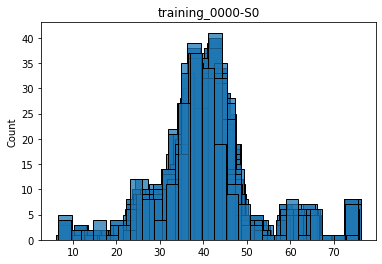

100%|██████████| 49/49 [00:02<00:00, 20.06it/s]


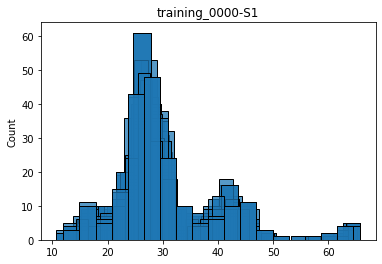

100%|██████████| 49/49 [00:02<00:00, 21.61it/s]


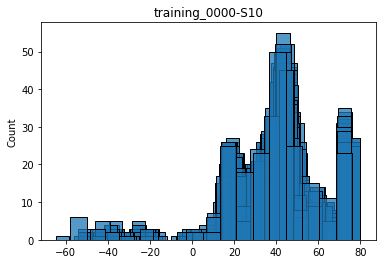

100%|██████████| 49/49 [00:03<00:00, 15.92it/s]


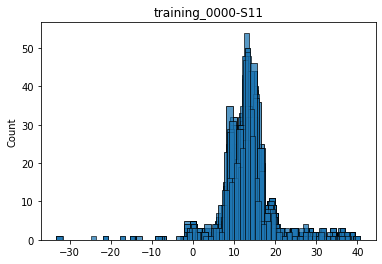

100%|██████████| 49/49 [00:01<00:00, 27.62it/s]


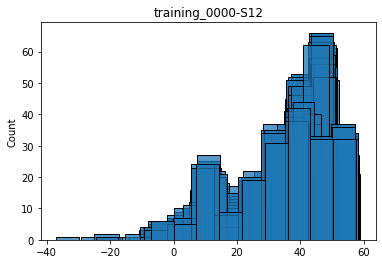

100%|██████████| 49/49 [00:01<00:00, 36.59it/s]


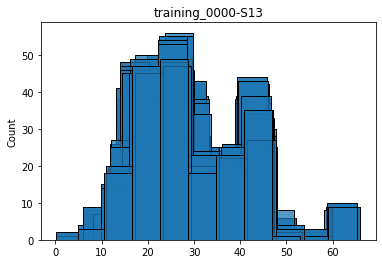

100%|██████████| 49/49 [00:01<00:00, 31.29it/s]


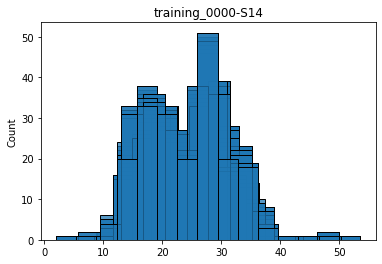

100%|██████████| 49/49 [00:01<00:00, 29.88it/s]


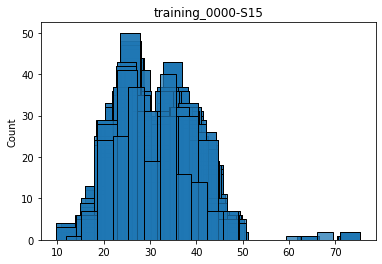

100%|██████████| 49/49 [00:03<00:00, 15.95it/s]


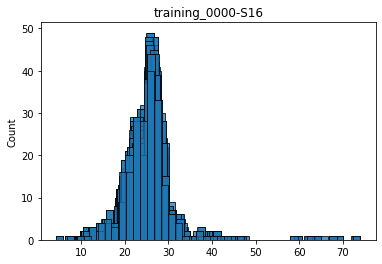

100%|██████████| 49/49 [00:02<00:00, 24.15it/s]


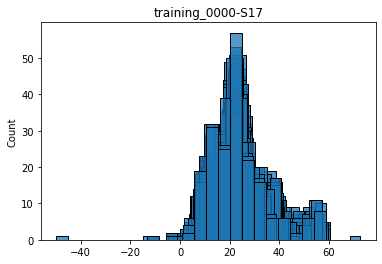

In [53]:
for scenario in test.index.unique()[:10]:
    plt.title(scenario)
    scenario_numbers = test_predictions_per_tree[test.index == scenario]
    sorted_by_mean = scenario_numbers[np.argsort(np.mean(scenario_numbers, axis=1))]
    for forest_trees in tqdm(sorted_by_mean[-1:-50:-1]):
        sns.histplot(forest_trees)
    plt.show()

100%|██████████| 50/50 [00:02<00:00, 24.25it/s]


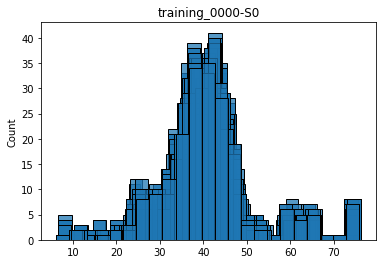

In [50]:
for scenario in test.index.unique():
    plt.title(scenario)
    scenario_numbers = test_predictions_per_tree[test.index == scenario]
    sorted_by_mean = scenario_numbers[np.argsort(np.mean(scenario_numbers, axis=1))]
    for forest_trees in tqdm(sorted_by_mean[-50:]):
        sns.histplot(forest_trees)
    plt.show()
    break

In [6]:
test.columns

Index(['D-conf', 'T-min-iou', 'T-max-age', 'T-every-nth-det',
       'avg_bbox_longevity', '90p_bbox_longevity', '90p_num_bboxes',
       '90p_bbox_speed', '90p_bbox_size', 'avg_num_bboxes', 'avg_bbox_speed',
       'avg_bbox_size', 'avg_ego_speed', 'D-model__efficientdet-d1',
       'D-model__efficientdet-d2', 'D-model__efficientdet-d3',
       'D-model__efficientdet-d4', 'D-model__efficientdet-d5',
       'D-model__efficientdet-d6', 'D-model__efficientdet-d7',
       'D-model__efficientdet-d7x', 'D-seq-pol__eager',
       'D-seq-pol__tail-aware', 'D-seq-pol__wait', 'T-model__sort',
       'time_of_day__Dawn/Dusk', 'time_of_day__Day', 'time_of_day__Night',
       'location__location_other', 'location__location_phx',
       'location__location_sf'],
      dtype='object')

In [7]:
from ad_config_search.utils import contract_one_hot

In [25]:
config_only_test = contract_one_hot(test)

In [26]:
config_only_test.columns

Index(['D-conf', 'T-min-iou', 'T-max-age', 'T-every-nth-det',
       'avg_bbox_longevity', '90p_bbox_longevity', '90p_num_bboxes',
       '90p_bbox_speed', '90p_bbox_size', 'avg_num_bboxes', 'avg_bbox_speed',
       'avg_bbox_size', 'avg_ego_speed', 'D-model', 'location', 'time_of_day',
       'D-seq-pol', 'T-model'],
      dtype='object')

In [27]:
config_only_test = config_only_test.drop(columns=['avg_bbox_longevity', '90p_bbox_longevity', '90p_num_bboxes', '90p_bbox_speed', '90p_bbox_size', 'avg_num_bboxes', 'avg_bbox_speed', 
                                                  'avg_bbox_size', 'avg_ego_speed', 'location', 'time_of_day'])
config_only_test = config_only_test.drop(columns=["T-model"])
config_only_test

,D-conf,T-min-iou,T-max-age,T-every-nth-det,D-model,D-seq-pol
training_0000-S0,0.3,0.1,1,1,efficientdet-d3,tail-aware
training_0000-S0,0.3,0.1,7,3,efficientdet-d5,wait
training_0000-S0,0.3,0.2,7,3,efficientdet-d5,eager
training_0000-S0,0.3,0.1,1,3,efficientdet-d1,eager
training_0000-S0,0.5,0.1,5,3,efficientdet-d5,wait
...,...,...,...,...,...,...
training_0005-S6,0.3,0.1,5,1,efficientdet-d2,wait
training_0005-S6,0.3,0.2,7,1,efficientdet-d2,wait
training_0005-S6,0.3,0.3,7,1,efficientdet-d7,tail-aware
training_0005-S6,0.3,0.2,5,5,efficientdet-d7,eager


In [21]:
with open("RF_test_policy_map_various_stats.pl", 'rb') as f:
    RF_tesT_policy_map_various_stats = pickle.load(f)

In [28]:
def get_best_config_by_score(scenario, metric_fn):
    best_row_index = np.argmax(metric_fn(test_predictions_per_tree[test.index == scenario]))
    return dict(config_only_test[test.index == scenario].iloc[best_row_index])

stats_per_pred = {
    metric_name: {scenario: get_best_config_by_score(scenario, metric_fn) for scenario in test.index.unique()} for metric_name, metric_fn in [
        ("p50", lambda x: np.percentile(x, 50, axis=1)),
        ("p25", lambda x: np.percentile(x, 25, axis=1)),
        ("p10", lambda x: np.percentile(x, 10, axis=1)),
        ("mean", lambda x: np.mean(x, axis=1))
    ]
}

#### get mean policy generated in RForest-AD-configs to see that the mean policy generated here is the same for sanity check

In [19]:
with open("RF_test_policy_map2.pl", 'rb') as f:
    mean_pol = pickle.load(f)

In [33]:
np.all([mean_pol[k] == stats_per_pred["mean"][k] for k in mean_pol])

True

In [34]:
with open("RF_test_policy_map_various_stats.pl", 'wb') as f:
    pickle.dump(stats_per_pred, f)